In [16]:
import uuid
from IPython.display import display, HTML

def create_hide_button():
    unique_id = str(uuid.uuid4())
    display(HTML('''
        <script>
        function toggle_output(button_id) {
            var output_area = document.getElementById(button_id).parentElement.parentElement.nextElementSibling;
            var button = document.getElementById(button_id);
            if (output_area.style.display === "none") {
                output_area.style.display = "block";
                button.innerHTML = "Hide Output";
            } else {
                output_area.style.display = "none";
                button.innerHTML = "Show Output";
            }
        }
        </script>
    '''))

    button_id = f"button_{unique_id}"
    display(HTML(f'''
        <button id="{button_id}" onclick="toggle_output('{button_id}')">Show Output</button>
        <script>
            document.getElementById('{button_id}').parentElement.parentElement.nextElementSibling.style.display = 'none';
        </script>
    '''))

In [17]:
from IPython.display import display, HTML

display(HTML('''<style>
    .jp-CodeCell .jp-InputArea {display: none;} /* Hide only code cells */
</style>'''))

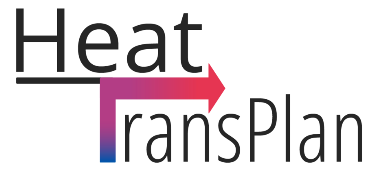


<div style="text-align: center; font-size: 50px;">
    <b>Energy and Sensor mapping on Process Data</b>
</div>

## Index
- [Define Paths and Load Datasets](#define-paths-and-load-datasets)
    - [Define Paths](#define-paths)
    - [Load Datasets](#load-datasets)
    - [Data Transformation and Cleaning](#data-transformation-and-cleaning)
- [Merge Datasets](#merge-datasets)
- [Map Process Data to Energy and Sensor Data](#map-process-data-to-energy-data-and-sensor-data)
- [Map Energy Data to Activities](#map-energy-data-to-activities)
    - [Map Electricity & Steam to each Activity](#map-electricity--steam-to-each-activity)
        - [Electricity](#electricity)
        - [Steam](#steam)
    - [Calculate Electricity and Steam Consmption for the whole Process](#calculate-electricity-and-steam-consumption-for-the-whole-process)
- [Merge Sensor Data](#merge-sensor-data)
    - [Merge Sensor Data on Activity Level](#merge-sensor-data-on-activity-level)
    - [Merge Sensor Data on Process Level](#merge-sensor-data-on-process-level)


In [18]:
import pandas as pd
import random
import itertools
import os
import numpy as np
from datetime import datetime, timedelta
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
#import simulation
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import chardet
import plotly.io as pio
from pathlib import Path
pio.renderers.default='notebook'
pd.options.mode.chained_assignment = None

# Define Paths and Load Datasets

## Define Paths

In [19]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
files_folder_bronze = current_path.parent.parent.parent / 'data' / 'bronze' / 'eckes_granini'
files_folder_bronze

PosixPath('/Users/davidzapata/Documents/GitHub/process_energy_demand_modelling/data/bronze/eckes_granini')

In [20]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/silver/aixit' folder relative to the current path
files_folder_silver = current_path.parent.parent.parent / 'data' / 'silver' / 'company_1'
files_folder_silver

PosixPath('/Users/davidzapata/Documents/GitHub/process_energy_demand_modelling/data/silver/company_1')

## Load Datasets

In [21]:
# load Aufträge PET2 08_2024
df_orders = pd.read_excel(files_folder_bronze/"Aufträge Energie Meldungen/Aufträge PET2 08_2024.xlsx", header=1, parse_dates=["StartTime", "EndTime"])
print(df_orders.columns)

df_orders.head()

Index(['OrderNumber', 'BF Product', 'BF Number', 'StartTime', 'EndTime',
       'ActualQuantity', 'SFG Product', 'SFG Brix-Density', 'Unnamed: 8'],
      dtype='object')


,OrderNumber,BF Product,BF Number,StartTime,EndTime,ActualQuantity,SFG Product,SFG Brix-Density,Unnamed: 8
0,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",4006719,2024-08-01 07:41:45,2024-08-01 13:28:09,59176,4501437,11.94,NaN
1,10705688,"BF 1,00 GR WeißeGrapefr N D01 PET Neu",4003635,2024-08-01 13:46:24,2024-08-01 15:47:52,19324,4500725,10.42,NaN
2,10705695,"BF 1,00 GR PinkGrapefruit D D01 PET",4007556,2024-08-01 16:21:32,2024-08-01 21:33:50,60104,4501667,9.32,NaN
3,10705698,"BF 1,00 GRTG PinkGrapefruit G DE PET",4007566,2024-08-01 21:26:12,2024-08-02 00:22:59,29706,4501667,9.32,NaN
4,10705696,"BF 1,00 GRTG Multi 50% N DE PET",4007561,2024-08-02 00:43:28,2024-08-02 15:46:51,177447,4501959,11.02,NaN


In [22]:
# load Meldungen PET2 KZE 08_2024
df_activities = pd.read_excel(files_folder_bronze/"Aufträge Energie Meldungen/Meldungen PET2 KZE 08_2024.xlsx", header=2, parse_dates=["Aufgetreten", "Gegangen"])
print(df_activities.columns)

df_activities.head()

Index(['Objektbezeichnung', 'Kommende Meldung', 'Aufgetreten', 'Gegangen'], dtype='object')


,Objektbezeichnung,Kommende Meldung,Aufgetreten,Gegangen
0,Status PET 2 KZE,gereinigt,2024-08-30 21:08:44,2024-08-30 21:08:44
1,Status PET 2 KZE,CIP,2024-08-30 17:44:18,2024-08-30 17:44:18
2,Erhitzer PET 2,Step-049 = CIP läuft,2024-08-30 17:44:18,2024-08-30 21:08:44
3,Rework PET 2,Step-013 = CIP läuft,2024-08-30 17:44:18,2024-08-30 21:08:44
4,Auslaugfefäß PET 2,Step-011 = CIP läuft,2024-08-30 17:44:18,2024-08-30 21:08:44


In [23]:
# load Energie Gesamtwerte
# Strom in kWh und Dampf in kg
df_energy_total = pd.read_excel(files_folder_bronze/"Aufträge Energie Meldungen/Energie Gesamtwerte PET2 KZE 08_2024.xlsx", header=0, parse_dates=["Datum / Uhrzeit"])
print(df_energy_total.columns)

df_energy_total.head()

Index(['Datum / Uhrzeit', 'Strom gesamt PET2 KZE',
       'Dampf gesamt PET2 KZE 30120FT801'],
      dtype='object')


,Datum / Uhrzeit,Strom gesamt PET2 KZE,Dampf gesamt PET2 KZE 30120FT801
0,2024-08-01 00:00:00,1.440505e+06,2262.295899
1,2024-08-01 00:15:00,1.440514e+06,2262.738900
2,2024-08-01 00:30:00,1.440523e+06,2262.738900
3,2024-08-01 00:45:00,1.440532e+06,2263.593392
4,2024-08-01 01:00:00,1.440542e+06,2264.034701


In [24]:
# load Energie Istwerte
# Strom in kW und Dampf in kg/h
df_energy_ist = pd.read_excel(files_folder_bronze/"Aufträge Energie Meldungen/Energie Istwerte PET2 KZE 08_2024.xlsx", header=0, parse_dates=["Datum / Uhrzeit"])
print(df_energy_ist.columns)

df_energy_ist.head()

Index(['Datum / Uhrzeit', 'Strom aktuell PET2 KZE',
       'Dampf aktuell PET2 KZE 30120FT801'],
      dtype='object')


,Datum / Uhrzeit,Strom aktuell PET2 KZE,Dampf aktuell PET2 KZE 30120FT801
0,2024-08-01 00:00:00,36.914555,2.0
1,2024-08-01 00:00:05,37.692829,2.0
2,2024-08-01 00:00:10,37.768864,2.0
3,2024-08-01 00:00:15,37.661293,2.0
4,2024-08-01 00:00:20,37.655125,2.0


In [25]:
#load sensor data
df_sensor = pd.read_parquet(files_folder_silver / 'df_sensor_joined.parquet')
df_sensor

,datetime,temp_Auslauf_EG_(WT2)_5s,temp_Einlauf_EG_(WT_2)_5s,flow_Kuehlturmwasser_30120FT701_5s,flow_Kaltwasser_(WT7)_5s,Kuehlturmwassertemp_(WT6)_5s,Kaltwassertemp_(WT_7)_5s,nach_Kuehler_(WT7)_5s,temp_nach_Kuehlturmkuehler_(WT6)_5s,Fuellstand_Steriltank_30140LT001_5s,...,temp_nach_Austauscher_2_(WT4)_5s,Druck_HW_Anwaermer_(WT3a)_5s,temp_HW_Anwaermer_(WT3a)_5s,temp_Produkt_Einlauf_30110TT001_1h,flow_Vorlaufpumpe_30110FT301_1h,temp_vor_Vorwärmer_(WT_2)_1h,strom_PERT2_KZE_5s,dampf_PET2_KZE_5s,strom_gesamt_PERT2_KZE_15m,dampf_gesamt_PET2_KZE_15m
0,2024-08-01 00:00:00,57.299999,56.700001,32022.0,56475.0,17.600000,16.400000,15.700000,17.700001,0.0,...,61.500000,2.19,52.000000,13.062797,20968.382277,56.842858,36.914555,2.0,1.440505e+06,2262.295899
1,2024-08-01 00:00:05,57.400002,56.700001,31987.0,56484.0,17.600000,16.400000,15.700000,17.600000,0.0,...,61.400002,2.20,52.000000,13.062797,20968.382277,56.842858,37.692829,2.0,NaN,NaN
2,2024-08-01 00:00:10,57.299999,56.700001,32048.0,56475.0,17.600000,16.400000,15.800000,17.700001,0.0,...,61.400002,2.20,52.099998,13.062797,20968.382277,56.842858,37.768864,2.0,NaN,NaN
3,2024-08-01 00:00:15,57.299999,56.799999,31979.0,56467.0,17.500000,16.400000,15.800000,17.700001,0.0,...,61.400002,2.19,52.099998,13.062797,20968.382277,56.842858,37.661293,2.0,NaN,NaN
4,2024-08-01 00:00:20,57.299999,56.700001,31970.0,56484.0,17.500000,16.400000,15.800000,17.700001,0.0,...,61.500000,2.20,52.099998,13.062797,20968.382277,56.842858,37.655125,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528494,2024-08-31 23:59:20,32.500000,32.700001,8.0,17.0,32.799999,33.400002,32.799999,31.799999,0.0,...,36.200001,2.13,36.700001,33.037872,5.999976,34.367041,0.607903,2.0,NaN,NaN
528495,2024-08-31 23:59:25,32.599998,32.599998,8.0,17.0,32.799999,33.400002,32.799999,31.799999,0.0,...,36.299999,2.13,36.700001,33.037872,5.999976,34.367041,0.617285,2.0,NaN,NaN
528496,2024-08-31 23:59:30,32.599998,32.599998,8.0,17.0,32.799999,33.500000,32.799999,31.799999,0.0,...,36.200001,2.13,36.599998,33.037872,5.999976,34.367041,0.609878,2.0,NaN,NaN
528497,2024-08-31 23:59:35,32.599998,32.700001,8.0,17.0,32.900002,33.299999,32.799999,31.799999,0.0,...,36.200001,2.13,36.700001,33.037872,5.999976,34.367041,0.602146,2.0,NaN,NaN


## Data Transformation and Cleaning

In [26]:
#transform Objektbezeichnungen as PET 2 and PET is the same and we can eliminate them
words = ["PET 2", "PET"]

for w in words:
    df_activities["Objektbezeichnung"] = df_activities["Objektbezeichnung"].str.replace(w, "", regex=False)

df_activities["Objektbezeichnung"] = df_activities["Objektbezeichnung"].str.strip()

In [27]:
#drop every Objektbezeichnung except Erhitzer
df_activities = df_activities[df_activities["Objektbezeichnung"] == "Erhitzer"]

In [28]:
df_activities.head()

,Objektbezeichnung,Kommende Meldung,Aufgetreten,Gegangen
2,Erhitzer,Step-049 = CIP läuft,2024-08-30 17:44:18,2024-08-30 21:08:44
9,Erhitzer,Step-047 = Anlage Stop,2024-08-30 17:08:18,2024-08-30 17:08:58
11,Erhitzer,Step-046 = Anlage Abfahren,2024-08-30 17:05:46,2024-08-30 17:08:18
25,Erhitzer,Step-020 = Sterilwasserumlauf (über VLG),2024-08-30 16:38:35,2024-08-30 17:05:46
41,Erhitzer,Step-035 = Ausschub Anlage,2024-08-30 16:23:08,2024-08-30 16:38:35


# Merge Datasets

### Merge Orders and Activities

In [29]:
#mapping data according to timestamps
# Funktion zum Mapping
def map_order(row, orders_df):
    matched_order = orders_df[
        (orders_df["StartTime"] <= row["Aufgetreten"]) & 
        (orders_df["EndTime"] >= row["Gegangen"])
    ]
    return matched_order.iloc[0]["OrderNumber"] if not matched_order.empty else None

# Mapping durchführen
df_activities["OrderNumber"] = df_activities.apply(map_order, orders_df=df_orders, axis=1)

# DataFrames zusammenführen
df_orders_activities = pd.merge(df_orders, df_activities, on="OrderNumber", how="left", suffixes=("_Order", "_Activity"))

#merge Objektbezeichnung and Kommende Meldung so that we can use it as Activity Name in the sense of Process Mining
df_orders_activities["ActivityName"] = df_orders_activities["Objektbezeichnung"] + " " + df_orders_activities["Kommende Meldung"]

#rename columns to differentiate between Timestamps of total order and the single activities
df_orders_activities = df_orders_activities.rename(columns={"StartTime": "StartTime_Order", "EndTime": "EndTime_Order", "Aufgetreten": "StartTime_Activity", "Gegangen": "EndTime_Activity"})

#sort according to timestamp StartTime_Activity
df_orders_activities = df_orders_activities.sort_values(by="StartTime_Activity")

#transform and clean
df_orders_activities = df_orders_activities.drop(columns=["Unnamed: 8"])
df_orders_activities = df_orders_activities.dropna(subset=["StartTime_Activity"])

# Ergebnis speichern
df_orders_activities.to_parquet(files_folder_silver/"order_activity_merged.parquet", index=False)

In [30]:
df_orders_activities.head()

,OrderNumber,BF Product,BF Number,StartTime_Order,EndTime_Order,ActualQuantity,SFG Product,SFG Brix-Density,Objektbezeichnung,Kommende Meldung,StartTime_Activity,EndTime_Activity,ActivityName
23,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",4006719,2024-08-01 07:41:45,2024-08-01 13:28:09,59176,4501437,11.94,Erhitzer,Step-032 = Umlauf,2024-08-01 07:58:56,2024-08-01 08:01:27,Erhitzer Step-032 = Umlauf
22,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",4006719,2024-08-01 07:41:45,2024-08-01 13:28:09,59176,4501437,11.94,Erhitzer,Step-030 = Produktion,2024-08-01 08:01:27,2024-08-01 08:41:47,Erhitzer Step-030 = Produktion
21,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",4006719,2024-08-01 07:41:45,2024-08-01 13:28:09,59176,4501437,11.94,Erhitzer,Step-032 = Umlauf,2024-08-01 08:41:47,2024-08-01 08:44:26,Erhitzer Step-032 = Umlauf
20,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",4006719,2024-08-01 07:41:45,2024-08-01 13:28:09,59176,4501437,11.94,Erhitzer,Step-030 = Produktion,2024-08-01 08:44:26,2024-08-01 09:14:02,Erhitzer Step-030 = Produktion
19,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",4006719,2024-08-01 07:41:45,2024-08-01 13:28:09,59176,4501437,11.94,Erhitzer,Step-032 = Umlauf,2024-08-01 09:14:02,2024-08-01 09:17:22,Erhitzer Step-032 = Umlauf


In [31]:
#sich überlappende Aktivitäten anzeigen

df = df_orders_activities.copy()

# Nach Order und Startzeit sortieren
df = df.sort_values(["OrderNumber", "StartTime_Activity"])

# Pro Order die nächste Startzeit "daneben legen"
df["Next_Start"] = df.groupby("OrderNumber")["StartTime_Activity"].shift(-1)

# Überschneidung, wenn: Ende der aktuellen Aktivität > Start der nächsten
df["Overlap_with_next"] = df["EndTime_Activity"] > df["Next_Start"]

# Alle Zeilen, bei denen eine Überschneidung auftritt
overlaps = df[df["Overlap_with_next"] == True]

print(overlaps)

problem = df[df["Overlap_with_next"]].copy()

# zur Info die nächste Aktivität dazuholen
problem["Next_ActivityName"] = df.groupby("OrderNumber")["ActivityName"].shift(-1)
problem["Next_End"] = df.groupby("OrderNumber")["EndTime_Activity"].shift(-1)

problem[[
    "OrderNumber",
    "ActivityName",
    "StartTime_Activity",
    "EndTime_Activity",
    "Next_ActivityName",
    "Next_Start",
    "Next_End"
]]

Empty DataFrame
Columns: [OrderNumber, BF Product, BF Number, StartTime_Order, EndTime_Order, ActualQuantity, SFG Product, SFG Brix-Density, Objektbezeichnung, Kommende Meldung, StartTime_Activity, EndTime_Activity, ActivityName, Next_Start, Overlap_with_next]
Index: []


,OrderNumber,ActivityName,StartTime_Activity,EndTime_Activity,Next_ActivityName,Next_Start,Next_End
26,NaN,NaN,NaT,NaT,Erhitzer Step-030 = Produktion,NaT,2024-08-01 15:41:16
25,NaN,NaN,NaT,NaT,Erhitzer Step-032 = Umlauf,NaT,2024-08-01 15:41:56
24,NaN,NaN,NaT,NaT,NaN,NaT,NaT
23,NaN,NaN,NaT,NaT,Erhitzer Step-030 = Produktion,NaT,2024-08-01 08:41:47
22,NaN,NaN,NaT,NaT,Erhitzer Step-032 = Umlauf,NaT,2024-08-01 08:44:26
...,...,...,...,...,...,...,...
1590,NaN,NaN,NaT,NaT,Erhitzer Step-030 = Produktion,NaT,2024-08-29 09:46:08
1589,NaN,NaN,NaT,NaT,Erhitzer Step-032 = Umlauf,NaT,2024-08-29 10:06:06
1588,NaN,NaN,NaT,NaT,Erhitzer Step-033 = Produkttausch,NaT,2024-08-29 10:10:54
1587,NaN,NaN,NaT,NaT,Erhitzer Step-035 = Ausschub Anlage,NaT,2024-08-29 10:21:05


### Merge Energy Ist and Sensor Data (5 Sek interval)

In [39]:
df_energy_ist["ts"] = pd.to_datetime(df_energy_ist["Datum / Uhrzeit"])
df_energy_ist = df_energy_ist.sort_values("ts")

df_sensor["ts"] = pd.to_datetime(df_sensor["datetime"])
df_sensor = df_sensor.sort_values("ts")

df_energy_sensor = pd.merge_asof(
    df_energy_ist,
    df_sensor.drop(columns=["datetime"], errors="ignore"),
    on="ts",
    direction="nearest",
)

df_energy_sensor

,Datum / Uhrzeit,Strom aktuell PET2 KZE,Dampf aktuell PET2 KZE 30120FT801,ts,temp_Auslauf_EG_(WT2)_5s,temp_Einlauf_EG_(WT_2)_5s,flow_Kuehlturmwasser_30120FT701_5s,flow_Kaltwasser_(WT7)_5s,Kuehlturmwassertemp_(WT6)_5s,Kaltwassertemp_(WT_7)_5s,...,temp_nach_Austauscher_2_(WT4)_5s,Druck_HW_Anwaermer_(WT3a)_5s,temp_HW_Anwaermer_(WT3a)_5s,temp_Produkt_Einlauf_30110TT001_1h,flow_Vorlaufpumpe_30110FT301_1h,temp_vor_Vorwärmer_(WT_2)_1h,strom_PERT2_KZE_5s,dampf_PET2_KZE_5s,strom_gesamt_PERT2_KZE_15m,dampf_gesamt_PET2_KZE_15m
0,2024-08-01 00:00:00,36.914555,2.0,2024-08-01 00:00:00,57.299999,56.700001,32022.0,56475.0,17.600000,16.400000,...,61.500000,2.19,52.000000,13.062797,20968.382277,56.842858,36.914555,2.0,1.440505e+06,2262.295899
1,2024-08-01 00:00:05,37.692829,2.0,2024-08-01 00:00:05,57.400002,56.700001,31987.0,56484.0,17.600000,16.400000,...,61.400002,2.20,52.000000,13.062797,20968.382277,56.842858,37.692829,2.0,NaN,NaN
2,2024-08-01 00:00:10,37.768864,2.0,2024-08-01 00:00:10,57.299999,56.700001,32048.0,56475.0,17.600000,16.400000,...,61.400002,2.20,52.099998,13.062797,20968.382277,56.842858,37.768864,2.0,NaN,NaN
3,2024-08-01 00:00:15,37.661293,2.0,2024-08-01 00:00:15,57.299999,56.799999,31979.0,56467.0,17.500000,16.400000,...,61.400002,2.19,52.099998,13.062797,20968.382277,56.842858,37.661293,2.0,NaN,NaN
4,2024-08-01 00:00:20,37.655125,2.0,2024-08-01 00:00:20,57.299999,56.700001,31970.0,56484.0,17.500000,16.400000,...,61.500000,2.20,52.099998,13.062797,20968.382277,56.842858,37.655125,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535969,2024-08-31 23:59:35,0.602146,2.0,2024-08-31 23:59:35,32.599998,32.700001,8.0,17.0,32.900002,33.299999,...,36.200001,2.13,36.700001,33.037872,5.999976,34.367041,0.602146,2.0,NaN,NaN
535970,2024-08-31 23:59:40,0.613449,2.0,2024-08-31 23:59:40,32.500000,32.700001,8.0,17.0,32.799999,33.400002,...,36.099998,2.13,36.700001,33.037872,5.999976,34.367041,0.613449,2.0,NaN,NaN
535971,2024-08-31 23:59:45,0.611671,NaN,2024-08-31 23:59:45,32.500000,32.700001,8.0,17.0,32.799999,33.400002,...,36.099998,2.13,36.700001,33.037872,5.999976,34.367041,0.613449,2.0,NaN,NaN
535972,2024-08-31 23:59:50,0.611923,2.0,2024-08-31 23:59:50,32.500000,32.700001,8.0,17.0,32.799999,33.400002,...,36.099998,2.13,36.700001,33.037872,5.999976,34.367041,0.613449,2.0,NaN,NaN


# Map Process Data to Energy Data and Sensor Data

In [40]:
# map process data to energy data

df_act = df_orders_activities.sort_values("StartTime_Activity")

act_cols = [
    "OrderNumber", "BF Product", "BF Number", "ActualQuantity",
    "StartTime_Order", "EndTime_Order",
    "ActivityName", "StartTime_Activity", "EndTime_Activity",
    "Objektbezeichnung", "Kommende Meldung"
]

tmp = pd.merge_asof(
    df_energy_sensor,
    df_act[act_cols],
    left_on="ts",
    right_on="StartTime_Activity",
    direction="backward"
)

# gültig nur wenn ts innerhalb des Aktivitätsintervalls liegt
mask_valid = tmp["EndTime_Activity"].notna() & (tmp["ts"] <= tmp["EndTime_Activity"])

# wenn ungültig: ALLE Prozessspalten leeren
tmp.loc[~mask_valid, act_cols] = None

df_energy_sensors_process_5s = tmp

df_energy_sensors_process_5s = tmp.drop(columns=["ts"])
df_energy_sensors_process_5s = df_energy_sensors_process_5s.rename(
    columns={"Datum / Uhrzeit": "datetime"}
)

df_energy_sensors_process_5s.to_csv(files_folder_silver/"Aufträge_Energy_Sensor_merged.csv", index=False)

df_energy_sensors_process_5s.head()


,datetime,Strom aktuell PET2 KZE,Dampf aktuell PET2 KZE 30120FT801,temp_Auslauf_EG_(WT2)_5s,temp_Einlauf_EG_(WT_2)_5s,flow_Kuehlturmwasser_30120FT701_5s,flow_Kaltwasser_(WT7)_5s,Kuehlturmwassertemp_(WT6)_5s,Kaltwassertemp_(WT_7)_5s,nach_Kuehler_(WT7)_5s,...,BF Product,BF Number,ActualQuantity,StartTime_Order,EndTime_Order,ActivityName,StartTime_Activity,EndTime_Activity,Objektbezeichnung,Kommende Meldung
0,2024-08-01 00:00:00,36.914555,2.0,57.299999,56.700001,32022.0,56475.0,17.6,16.4,15.7,...,None,NaN,NaN,NaT,NaT,None,NaT,NaT,None,None
1,2024-08-01 00:00:05,37.692829,2.0,57.400002,56.700001,31987.0,56484.0,17.6,16.4,15.7,...,None,NaN,NaN,NaT,NaT,None,NaT,NaT,None,None
2,2024-08-01 00:00:10,37.768864,2.0,57.299999,56.700001,32048.0,56475.0,17.6,16.4,15.8,...,None,NaN,NaN,NaT,NaT,None,NaT,NaT,None,None
3,2024-08-01 00:00:15,37.661293,2.0,57.299999,56.799999,31979.0,56467.0,17.5,16.4,15.8,...,None,NaN,NaN,NaT,NaT,None,NaT,NaT,None,None
4,2024-08-01 00:00:20,37.655125,2.0,57.299999,56.700001,31970.0,56484.0,17.5,16.4,15.8,...,None,NaN,NaN,NaT,NaT,None,NaT,NaT,None,None


# Map Energy Data to Activities

In [41]:
df_orders_activities_energy = df_orders_activities

# Dauer einzelner Aktivitäten berechnen
df_orders_activities_energy["dauer_activity_s"] = (df_orders_activities_energy["EndTime_Activity"] - df_orders_activities_energy["StartTime_Activity"]).dt.total_seconds()
df_orders_activities_energy["dauer_activity_h"] = df_orders_activities_energy["dauer_activity_s"] / 3600

## Map Electricity & Steam to each Activity

### Electricity

In [42]:
# Berechnung der momentanten Stromleistung für jede Aktivität
# Energie aus 5-Sekunden-Leistungswerten berechnen
# Annahme: "Strom aktuell PET2 KZE" ist Leistung in kW
# Energie für jedes 5-Sekunden intervall ist in kWh
MESS_INTERVALL_S = 5  # Sekunden
df_energy_ist["Strom_kWh"] = df_energy_ist["Strom aktuell PET2 KZE"] * (MESS_INTERVALL_S / 3600)

# Funktion: Energie für eine Aktivität (Start/Ende) aufsummieren
def energy_for_activity(row):
    start = row["StartTime_Activity"]
    end   = row["EndTime_Activity"]
    
    # alle Messpunkte, die in das Aktivitätsfenster fallen
    mask = (df_energy_ist["Datum / Uhrzeit"] >= start) & (df_energy_ist["Datum / Uhrzeit"] < end)
    
    # kWh über dieses Zeitfenster aufsummieren
    return df_energy_ist.loc[mask, "Strom_kWh"].sum()

# Auf alle Aktivitäten anwenden
df_orders_activities_energy["Strom_kWh"] = df_orders_activities_energy.apply(energy_for_activity, axis=1)

In [43]:
# Berechnung der tatsächlich verbrauchten Menge an Strom pro Aktivität
df_orders_activities_energy["Strom_kW"] = df_orders_activities_energy["Strom_kWh"] / df_orders_activities_energy["dauer_activity_h"]

In [44]:
print(df_orders_activities_energy[
    ["ActivityName", "Strom_kWh", "Strom_kW", "dauer_activity_h"]
])

                                           ActivityName  Strom_kWh   Strom_kW  \
23                           Erhitzer Step-032 = Umlauf   1.351515  32.221559   
22                       Erhitzer Step-030 = Produktion  18.383563  27.347449   
21                           Erhitzer Step-032 = Umlauf   1.423124  32.221672   
20                       Erhitzer Step-030 = Produktion  13.571918  27.510644   
19                           Erhitzer Step-032 = Umlauf   1.812333  32.621986   
...                                                 ...        ...        ...   
1675                         Erhitzer Step-032 = Umlauf   0.269873  40.480982   
1674                Erhitzer Step-035 = Ausschub Anlage   8.668996  33.666003   
1673  Erhitzer Step-020 = Sterilwasserumlauf (über VLG)  10.866803  23.985585   
1672                Erhitzer Step-046 = Anlage Abfahren   0.873813  20.695577   
1671                    Erhitzer Step-047 = Anlage Stop   0.036639   3.297554   

      dauer_activity_h  
23

### Steam

In [45]:
# Energie aus 5-Sekunden-Leistungswerten berechnen
# Annahme: "Dampf aktuell PET2 KZE 30120FT801" ist Leistung in kg/h
MESS_INTERVALL_S = 5  # Sekunden
df_energy_ist["Dampf_kg"] = df_energy_ist["Dampf aktuell PET2 KZE 30120FT801"] * (MESS_INTERVALL_S / 3600)

# Funktion: Energie für eine Aktivität (Start/Ende) aufsummieren
def energy_for_activity(row):
    start = row["StartTime_Activity"]
    end   = row["EndTime_Activity"]
    
    # alle Messpunkte, die in das Aktivitätsfenster fallen
    mask = (df_energy_ist["Datum / Uhrzeit"] >= start) & (df_energy_ist["Datum / Uhrzeit"] < end)
    
    # kWh über dieses Zeitfenster aufsummieren
    return df_energy_ist.loc[mask, "Dampf_kg"].sum()


# Auf alle Aktivitäten anwenden
df_orders_activities_energy["Dampf_kg"] = df_orders_activities_energy.apply(energy_for_activity, axis=1)

In [46]:
# Berechnung der tatsächlich verbrauchten Menge an Dampf pro Aktivität
df_orders_activities_energy["Dampf_kg_h"] = df_orders_activities_energy["Dampf_kg"] / df_orders_activities_energy["dauer_activity_h"]

In [47]:
df_orders_activities_energy

,OrderNumber,BF Product,BF Number,StartTime_Order,EndTime_Order,ActualQuantity,SFG Product,SFG Brix-Density,Objektbezeichnung,Kommende Meldung,StartTime_Activity,EndTime_Activity,ActivityName,dauer_activity_s,dauer_activity_h,Strom_kWh,Strom_kW,Dampf_kg,Dampf_kg_h
23,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",4006719,2024-08-01 07:41:45,2024-08-01 13:28:09,59176,4501437,11.94,Erhitzer,Step-032 = Umlauf,2024-08-01 07:58:56,2024-08-01 08:01:27,Erhitzer Step-032 = Umlauf,151.0,0.041944,1.351515,32.221559,0.083333,1.986755
22,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",4006719,2024-08-01 07:41:45,2024-08-01 13:28:09,59176,4501437,11.94,Erhitzer,Step-030 = Produktion,2024-08-01 08:01:27,2024-08-01 08:41:47,Erhitzer Step-030 = Produktion,2420.0,0.672222,18.383563,27.347449,1.333333,1.983471
21,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",4006719,2024-08-01 07:41:45,2024-08-01 13:28:09,59176,4501437,11.94,Erhitzer,Step-032 = Umlauf,2024-08-01 08:41:47,2024-08-01 08:44:26,Erhitzer Step-032 = Umlauf,159.0,0.044167,1.423124,32.221672,0.088889,2.012579
20,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",4006719,2024-08-01 07:41:45,2024-08-01 13:28:09,59176,4501437,11.94,Erhitzer,Step-030 = Produktion,2024-08-01 08:44:26,2024-08-01 09:14:02,Erhitzer Step-030 = Produktion,1776.0,0.493333,13.571918,27.510644,0.977778,1.981982
19,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",4006719,2024-08-01 07:41:45,2024-08-01 13:28:09,59176,4501437,11.94,Erhitzer,Step-032 = Umlauf,2024-08-01 09:14:02,2024-08-01 09:17:22,Erhitzer Step-032 = Umlauf,200.0,0.055556,1.812333,32.621986,0.108333,1.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,10709874,"BF 0,75 GRSEN MINTY MELON G DE PET",4005985,2024-08-30 00:13:47,2024-08-30 18:44:13,207613,4501305,11.02,Erhitzer,Step-032 = Umlauf,2024-08-30 16:22:44,2024-08-30 16:23:08,Erhitzer Step-032 = Umlauf,24.0,0.006667,0.269873,40.480982,2.390278,358.541667
1674,10709874,"BF 0,75 GRSEN MINTY MELON G DE PET",4005985,2024-08-30 00:13:47,2024-08-30 18:44:13,207613,4501305,11.02,Erhitzer,Step-035 = Ausschub Anlage,2024-08-30 16:23:08,2024-08-30 16:38:35,Erhitzer Step-035 = Ausschub Anlage,927.0,0.257500,8.668996,33.666003,53.991667,209.676375
1673,10709874,"BF 0,75 GRSEN MINTY MELON G DE PET",4005985,2024-08-30 00:13:47,2024-08-30 18:44:13,207613,4501305,11.02,Erhitzer,Step-020 = Sterilwasserumlauf (über VLG),2024-08-30 16:38:35,2024-08-30 17:05:46,Erhitzer Step-020 = Sterilwasserumlauf (über VLG),1631.0,0.453056,10.866803,23.985585,32.731944,72.247088
1672,10709874,"BF 0,75 GRSEN MINTY MELON G DE PET",4005985,2024-08-30 00:13:47,2024-08-30 18:44:13,207613,4501305,11.02,Erhitzer,Step-046 = Anlage Abfahren,2024-08-30 17:05:46,2024-08-30 17:08:18,Erhitzer Step-046 = Anlage Abfahren,152.0,0.042222,0.873813,20.695577,0.080556,1.907895


In [56]:
df_orders_activities_energy.to_parquet(files_folder_silver/"orders_activity_sensors.parquet", index=False)

## Calculate Electricity and Steam Consumption for the whole Process

In [49]:
# Gruppierung nach OrderNumber
group_cols = ["OrderNumber"] 

df_orders_energy = (
    df_orders_activities_energy
    .groupby(group_cols)
    .agg(
        Product = ("BF Product", "min"),
        Strom_kWh_total = ("Strom_kWh", "sum"),
        Dampf_kg_total  = ("Dampf_kg", "sum"),
        Start_Prozess   = ("StartTime_Order", "min"),
        Ende_Prozess    = ("EndTime_Order", "max"),
    )
    .reset_index()
)

# Prozessdauer in Stunden berechnen (optional für Durchschnittswerte)
df_orders_energy["Prozessdauer_h"] = (
    df_orders_energy["Ende_Prozess"] - df_orders_energy["Start_Prozess"]
).dt.total_seconds() / 3600

# Durchschnittliche Leistungen über den ganzen Prozess (optional)
df_orders_energy["Strom_kW_avg"]   = df_orders_energy["Strom_kWh_total"] / df_orders_energy["Prozessdauer_h"]
df_orders_energy["Dampf_kg_h_avg"] = df_orders_energy["Dampf_kg_total"]   / df_orders_energy["Prozessdauer_h"]

df_orders_energy = df_orders_energy.sort_values(by="Start_Prozess")
df_orders_energy

,OrderNumber,Product,Strom_kWh_total,Dampf_kg_total,Start_Prozess,Ende_Prozess,Prozessdauer_h,Strom_kW_avg,Dampf_kg_h_avg
1,10705690,"BF 1,00 GRTG Apfel trüb S DE PET",161.145953,10.847222,2024-08-01 07:41:45,2024-08-01 13:28:09,5.773333,27.912117,1.878849
0,10705688,"BF 1,00 GR WeißeGrapefr N D01 PET Neu",8.993484,0.630556,2024-08-01 13:46:24,2024-08-01 15:47:52,2.024444,4.442445,0.311471
2,10705695,"BF 1,00 GR PinkGrapefruit D D01 PET",91.294280,6.575000,2024-08-01 16:21:32,2024-08-01 21:33:50,5.205000,17.539727,1.263208
4,10705698,"BF 1,00 GRTG PinkGrapefruit G DE PET",25.065866,1.558333,2024-08-01 21:26:12,2024-08-02 00:22:59,2.946389,8.507318,0.528896
3,10705696,"BF 1,00 GRTG Multi 50% N DE PET",412.290193,109.731944,2024-08-02 00:43:28,2024-08-02 15:46:51,15.056389,27.383073,7.288065
5,10705703,"BF 1,00 GRTG Orange 50% N DE PET",43.369710,162.525000,2024-08-02 16:05:42,2024-08-02 19:38:31,3.546944,12.227344,45.821129
11,10706584,"BF 0,85 HCAIO BEAUTY S DE PET",581.812791,3365.309722,2024-08-05 04:38:10,2024-08-05 22:13:26,17.587778,33.080518,191.343657
12,10706585,"BF 0,85 HCAIO EVERYDAY S DE PET",423.542168,1709.693056,2024-08-05 22:32:54,2024-08-06 11:07:09,12.570833,33.692450,136.004751
10,10706583,"BF 0,85 HCAIO RELOAD S DE PET",683.412616,3790.626389,2024-08-06 11:26:40,2024-08-07 03:32:35,16.098611,42.451651,235.462945
8,10706576,"BF 1,00 GRTG AppleCherry N DE PET",277.293576,1610.265278,2024-08-07 07:38:20,2024-08-07 14:52:23,7.234167,38.331101,222.591675


In [50]:
df_orders_energy.to_csv(files_folder_bronze/"AufträgeMeldungen_Orders_Energy_merged.csv", index=False)

# Merge Sensor Data

In [51]:
#create new dataframe with process information and sensor data and energy data
df_orders_activities_energy_sensor = df_orders_activities_energy

## Merge Sensor Data on Activity Level

In [52]:
list(df_sensor.columns)

['datetime',
 'temp_Auslauf_EG_(WT2)_5s',
 'temp_Einlauf_EG_(WT_2)_5s',
 'flow_Kuehlturmwasser_30120FT701_5s',
 'flow_Kaltwasser_(WT7)_5s',
 'Kuehlturmwassertemp_(WT6)_5s',
 'Kaltwassertemp_(WT_7)_5s',
 'nach_Kuehler_(WT7)_5s',
 'temp_nach_Kuehlturmkuehler_(WT6)_5s',
 'Fuellstand_Steriltank_30140LT001_5s',
 'Fuellstand_Steriltank_30141LT001_5s',
 'flow_Dampf_WT3a/5a)_5s',
 'flow_Heisswasser_30120FT721(WT5a)_5s',
 'temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s',
 'temp_nach_Erhitzer_(WT5)_5s',
 'temp_nach_WR2_(WT2)_5s',
 'temp_nach_Austauscher_2_(WT4)_5s',
 'Druck_HW_Anwaermer_(WT3a)_5s',
 'temp_HW_Anwaermer_(WT3a)_5s',
 'temp_Produkt_Einlauf_30110TT001_1h',
 'flow_Vorlaufpumpe_30110FT301_1h',
 'temp_vor_Vorwärmer_(WT_2)_1h',
 'strom_PERT2_KZE_5s',
 'dampf_PET2_KZE_5s',
 'strom_gesamt_PERT2_KZE_15m',
 'dampf_gesamt_PET2_KZE_15m',
 'ts']

In [ ]:
a

In [53]:
# 1. Funktion: Sensordaten über eine Aktivitätsdauer mitteln
def sensor_for_activity(row, col):
    start = row["StartTime_Activity"]
    end   = row["EndTime_Activity"]

    # alle Messpunkte innerhalb des Aktivitätsfensters
    mask = (df_sensor["datetime"] >= start) & (df_sensor["datetime"] < end)

    # Mittelwert der gewünschten Sensor-Spalte
    return df_sensor.loc[mask, col].mean()


# 2. Liste aller Sensor-Spalten, die du auswerten möchtest
sensor_cols = [ 'temp_Auslauf_EG_(WT2)_5s',
 'temp_Einlauf_EG_(WT_2)_5s',
 'flow_Kuehlturmwasser_30120FT701_5s',
 'flow_Kaltwasser_(WT7)_5s',
 'Kuehlturmwassertemp_(WT6)_5s',
 'Kaltwassertemp_(WT_7)_5s',
 'nach_Kuehler_(WT7)_5s',
 'temp_nach_Kuehlturmkuehler_(WT6)_5s',
 'Fuellstand_Steriltank_30140LT001_5s',
 'Fuellstand_Steriltank_30141LT001_5s',
 'flow_Dampf_WT3a/5a)_5s',
 'flow_Heisswasser_30120FT721(WT5a)_5s',
 'temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s',
 'temp_nach_Erhitzer_(WT5)_5s',
 'temp_nach_WR2_(WT2)_5s',
 'temp_nach_Austauscher_2_(WT4)_5s',
 'Druck_HW_Anwaermer_(WT3a)_5s',
 'temp_HW_Anwaermer_(WT3a)_5s',
 'temp_Produkt_Einlauf_30110TT001_1h',
 'flow_Vorlaufpumpe_30110FT301_1h',
 'temp_vor_Vorwärmer_(WT_2)_1h']


# 3. Mittelwerte je Aktivität berechnen und als neue Spalten anhängen
for col in sensor_cols:
    new_col_name = col.replace("_5s", "_mean").replace("_1h", "_mean")  # oder anderer Name
    df_orders_activities_energy_sensor[new_col_name] = df_orders_activities_energy_sensor.apply(
        sensor_for_activity,
        axis=1,
        col=col
    )

KeyboardInterrupt: 

In [ ]:
df_orders_activities_energy_sensor.head()

In [ ]:
df_orders_activities_energy_sensor.to_csv(files_folder_silver/"AufträgeMeldungen_Activities_Energy_Sensor_merged.csv", index=False)

## Merge Sensor Data on Process Level

In [ ]:
#get list of columns
list(df_orders_activities_energy_sensor.columns)

In [ ]:
# 1) Alle Spaltennamen automatisch holen
cols = df_orders_activities_energy_sensor.columns

# 2) Alle Sensor-Spalten finden, die auf "_mean" enden
mean_cols = [c for c in cols if c.endswith("_mean")]

# 3) Aggregations-Definition für groupby bauen
group_cols = ["OrderNumber"]

agg_dict = {
    "Product": ("BF Product", "min"),
    "Start_Prozess": ("StartTime_Order", "min"),
    "Ende_Prozess": ("EndTime_Order", "max"),
    "Strom_kWh_total": ("Strom_kWh", "sum"),
    "Dampf_kg_total": ("Dampf_kg", "sum"),
}

# Für alle *_mean-Spalten: noch einmal den Mittelwert über den gesamten Prozess bilden
# -> neue Spaltennamen optional ohne "_mean"
for c in mean_cols:
    new_name = c.replace("_mean", "")  # oder lass einfach c, wenn du den Namen behalten willst
    agg_dict[new_name] = (c, "mean")

# 4) Gruppierung nach OrderNumber und Aggregation
df_orders_energy_sensor = (
    df_orders_activities_energy_sensor
    .groupby(group_cols)
    .agg(**agg_dict)
    .reset_index()
)

# Prozessdauer in Stunden berechnen (optional für Durchschnittswerte)
df_orders_energy_sensor["Prozessdauer_h"] = (
    df_orders_energy_sensor["Ende_Prozess"] - df_orders_energy_sensor["Start_Prozess"]
).dt.total_seconds() / 3600

# Durchschnittliche Leistungen über den ganzen Prozess (optional)
df_orders_energy_sensor["Strom_kW_avg"]   = df_orders_energy_sensor["Strom_kWh_total"] / df_orders_energy_sensor["Prozessdauer_h"]
df_orders_energy_sensor["Dampf_kg_h_avg"] = df_orders_energy_sensor["Dampf_kg_total"]   / df_orders_energy_sensor["Prozessdauer_h"]

df_orders_energy_sensor = df_orders_energy_sensor.sort_values(by="Start_Prozess")
df_orders_energy_sensor.head()

In [ ]:
df_orders_energy_sensor.to_csv(files_folder_silver/"AufträgeMeldungen_Orders_Energy_Sensor_merged.csv", index=False)